# Baseline model

The first step is to load the data extracted from our transactional data (warehouse)
The queries used are saved in this repo for documentation purposes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
cart_items = pd.read_csv('data_git/cart_items.csv')


A bit about how the data is structured at Metaloop. We essentially have these sources of trasactional material data:

 - Cart items
    - These are the materials that compose a transaction (stored in the orders object). Each order is associated with two accounts, a seller and a buyer. Therefore, the lowest granularity data here will be cart item level data with data from the orders joined
 - Opportunity materials
    - These play a similar role as cart items, but on the opportunity level (prior to an order being put forward)
   
 - Conditions (Contract materials)

For the purpose of this baseline model, we will use only cart items data, which is our most comprehensive database.
 

## Simple bag of words model

With a simple bag of words model, we try to extract features from the alias, material and formula fields. Our target variable is the variable product_id, which is a class corresponding to the underlying product related to the material. This is encoded by the class in the `fk_material` column.

### The training of an NLP model

1. Preprocessing the text
2. Vectozing the text
3. Choose appropriate ML model to train

In [2]:
# Change ds_material_alias to string
cart_items['ds_material_alias'] = cart_items['ds_material_alias'].astype(str)

Next, we define functions to extract metadata about the text of the alias names

In [3]:
# Define function to count words
def count_words(string):
    return len(string.split())

# Define function to get the average word length
def avg_word_length(string):
    words = string.split()
    return sum(len(word) for word in words) / len(words)

# Check if the description has the percentage symbol
cart_items['flg_has_perc'] = cart_items['ds_material_alias'].apply(lambda x: len([c for c in x if c == '%'])>0)

# Create number of words for the two columns available
cart_items['n_words_alias'] = cart_items['ds_material_alias'].apply(count_words)

# Inspect results
cart_items.head()


,ds_sale_price_formula,ds_purchase_price_formula,ds_material_alias,vl_quantity_sell,vl_unit_price_sell,fk_material,cd_alias_language,cd_product_id,ds_category_en,ds_order_type,flg_has_perc,n_words_alias
0,NaN,NaN,Kupfer Raff Granulat,2163.0,6.10000,a0Z09000000H7jvEAC,de,60001.0,copper,wholesale - europe domestic,False,3
1,NaN,NaN,"Kupfer-Nickel, blank",17500.0,13.18583,a0Z09000005Ecu7EAC,de,600041.0,copper,wholesale - europe domestic,False,2
2,NaN,NaN,"Edelstahl, V2A, Nirosta, Niro",14560.0,2.01000,a0Z09000000oVRUEA2,de,18037.0,stainless steel,wholesale - europe domestic,False,4
3,NaN,NaN,"Edelstahl, V2A, Nirosta, Niro",1484.0,2.06000,a0Z09000000oVRUEA2,de,18037.0,stainless steel,wholesale - europe domestic,False,4
4,NaN,NaN,"Edelstahl, V4A Schrott",5980.0,2.80000,a0Z09000000oVWZEA2,de,18039.0,stainless steel,wholesale - europe domestic,False,3


In [4]:
# converting the data to lower case
cart_items['ds_material_alias'] = cart_items['ds_material_alias'].str.lower()

# Removing the leading and trailing whitespaces
cart_items['ds_material_alias'] = cart_items['ds_material_alias'].str.strip()

## Formula parsing


In [5]:
avg_1 = np.mean(cart_items['ds_sale_price_formula'].isna())

avg_2 = np.mean(cart_items['ds_purchase_price_formula'] == 'nan')

print(
    """
    avg_1: {}
    avg_2: {}""".format(avg_1, avg_2)
)


    avg_1: 0.9881590319792567
    avg_2: 0.0


In [6]:
import sys

module_path = 'models'
sys.path.append(module_path)

# Import the functions from the python file
import formula_parsing_function as fpf

# Apply the functions to the column

# Change formula type to
cart_items['ds_sale_price_formula'] = cart_items['ds_sale_price_formula'].astype(str)

# Detect currency
cart_items['currency'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_currency)

# Get operator
cart_items['operator'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_operator)

# Get index
cart_items['index'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_index)

# Get constant
cart_items['constant'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_constant)

# Convert to float
cart_items['constant'] = cart_items['constant'].apply(fpf.convert_constant)

# Get unit
cart_items['unit'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_unit)

# Identify if the price is fixed
cart_items['_price'] = cart_items['ds_sale_price_formula'].str.contains('fix')

### End of preprocessing
----

### Vectorization

Now that we have done the pre-processing of the text, we can work on vectorizing it. We will apply three simple methods to arrive at the baseline for the feature extraction of the text.

## Training

We will start now training the baseline model

Mean Squared Error:  2445.3920836546904


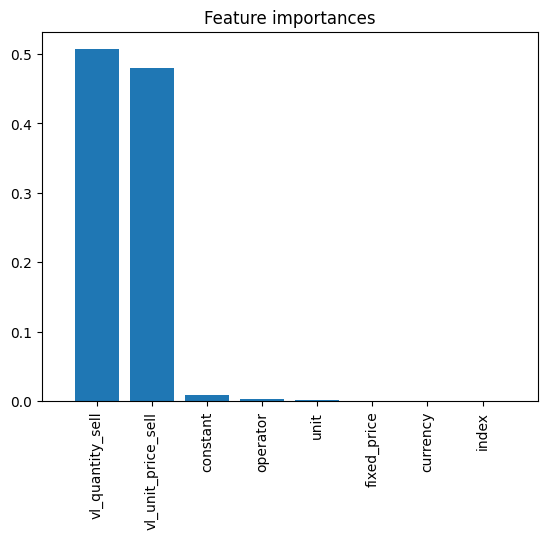

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Features and categorical feature indices
features = [
    'vl_quantity_sell', 'vl_unit_price_sell', 'currency', 'operator', 'index',
    'constant', 'unit', 'fixed_price'
]

categorical_features = [2, 3, 4, 6]  # Column indices of categorical features

label = ['fk_material']

# For categorical features, we can fill missing values with 'missing'
cart_items[['currency', 'operator', 'index', 'unit']] = cart_items[['currency', 'operator', 'index', 'unit']].fillna('missing')

# For numerical features, we can fill missing values with a statistic (here, I'm using zero)
cart_items[['vl_quantity_sell', 'vl_unit_price_sell', 'constant']] = cart_items[['vl_quantity_sell', 'vl_unit_price_sell', 'constant']].fillna(0)

# Declare the features and the label
X = cart_items[features].to_numpy()
y = cart_items[label].to_numpy()

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the categorical features using OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform the training data
X_train[:, categorical_features] = oe.fit_transform(X_train[:, categorical_features])

# Transform the testing data
X_test[:, categorical_features] = oe.transform(X_test[:, categorical_features])

# Fit and transform the tagets
y_train = oe.fit_transform(y_train)
y_test = oe.transform(y_test)

# Import the model and instantiate it
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train.ravel())  # Flatten y_train since it has the shape (n_samples, 1)

# Predict the model
y_pred = rf.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error: ", mse)

# Plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Next, we add the category, record type name, flag for percentage symbol in the alias and number of words as new features:

Mean Squared Error:  771.1904475100358


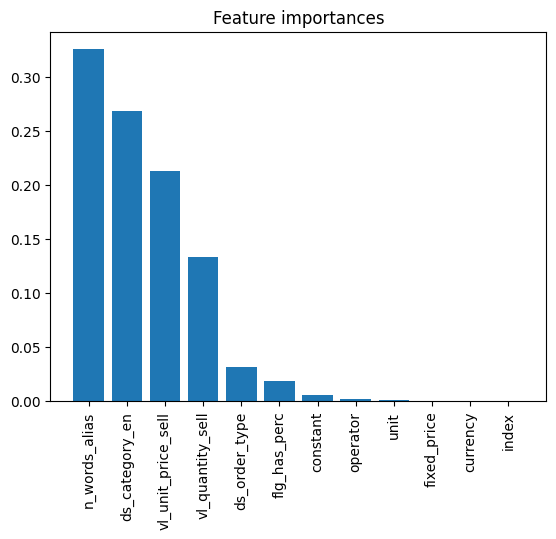

In [8]:
# Features and categorical feature indices
features = [
    'vl_quantity_sell', 'vl_unit_price_sell', 'currency', 'operator', 'index',
    'constant', 'unit', 'fixed_price', 'ds_category_en', 'ds_order_type', 'flg_has_perc', 'n_words_alias'
]

categorical_features = [2, 3, 4, 6, 8, 9, 11]  # Column indices of categorical features

label = ['fk_material']

# For categorical features, we can fill missing values with 'missing'
cart_items[['currency', 'operator', 'index', 'unit', 'ds_category_en', 'ds_order_type', 'flg_has_perc', 'n_words_alias']] = \
      cart_items[['currency', 'operator', 'index', 'unit', 'ds_category_en', 'ds_order_type', 'flg_has_perc', 'n_words_alias']].fillna('missing')

# For numerical features, we can fill missing values with a statistic (here, I'm using zero)
cart_items[['vl_quantity_sell', 'vl_unit_price_sell', 'constant']] = cart_items[['vl_quantity_sell', 'vl_unit_price_sell', 'constant']].fillna(0)

# Declare the features and the label
X = cart_items[features].to_numpy()
y = cart_items[label].to_numpy()

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the categorical features using OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform the training data
X_train[:, categorical_features] = oe.fit_transform(X_train[:, categorical_features])

# Transform the testing data
X_test[:, categorical_features] = oe.transform(X_test[:, categorical_features])

# Fit and transform the tagets
y_train = oe.fit_transform(y_train)
y_test = oe.transform(y_test)

# Import the model and instantiate it
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train.ravel())  # Flatten y_train since it has the shape (n_samples, 1)

# Predict the model
y_pred = rf.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error: ", mse)

# Plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Next, we compare the performance of this simplistic model to simply guessing the product based on frequency and the category

We will also compare it with just guessing the material based on simply guessing the most frequent product for each category

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Concatenate features and targets to create the full array
full_array = np.concatenate([X_test, y_test.reshape(-1, 1)], axis=1)

y_pred = np.zeros(y_test.shape)

# For each row in the test data
for i in range(X_test.shape[0]):
    # Get the category of the product
    category = X_test[i, 8]
    # Get all the products in the category
    category_products = full_array[full_array[:, 8] == category]
    
    # Get the products in the category and cast to integer, filter out negative values
    product_ids = category_products[:, -1].astype(int)
    product_ids = product_ids[product_ids >= 0]  # Filter out negative values
    
    # Only proceed if there are valid products in the category
    if len(product_ids) > 0:
        # Get the most common product in the category
        most_common_product = np.argmax(np.bincount(product_ids))
        # Assign the most common product to the prediction
        y_pred[i] = most_common_product
    else:
        # Handle the case where there are no valid products, e.g., by assigning a default value
        y_pred[i] = -1  # Or some other default value

# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  2780.7576707000862


We see that even without any fine-tuning, a simplistic model that predicts the product based on some available meta data about the transaction performs better than simply guessing the product based on the mode of the category. This is an expected result, as we are aware that the number of unique products is large (over 200 used) and therefore this model is not supposed to perform well. In the next step we will do some fine-tuning to this baseline model in order to get the baseline model to its best performance.

## Fine-tuning the baseline model

In this section we will fine tune the model for the baseline predictions and try different approaches to the problem.

In [12]:
# Iniitiate random search

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Import the model and instantiate it
rf = RandomForestRegressor()

# Fit the model to the different parameters
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train.ravel())  # Fit the model

# Print the best parameters
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   7.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   7.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   7.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=160

/Users/bernardocarvalho/Desktop/imperial_repos/work_based_project/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  24.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  25.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  22.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  22.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  22.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   0.0s
[CV] END bootstrap=False, max_depth

/Users/bernardocarvalho/Desktop/imperial_repos/work_based_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bernardocarvalho/Desktop/imperial_repos/work_based_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bernardocarvalho/Desktop/imperial_repos/work_based_project/venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/User

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [13]:
# Print mse for the best model
y_pred = rf_random.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  729.2401236144287


We see that with a random grid search, the improvements in the MSE were marginal. Of course there is a chance the optimal parameters combination was missed but we will try other models instead.

In [14]:
# Repeat training with svm

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Import the model and instantiate it
svr = make_pipeline(StandardScaler(), SVR())

# Fit the model
svr.fit(X_train, y_train.ravel())  # Flatten y_train since it has the shape (n_samples, 1)

# Predict the model
y_pred = svr.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error: ", mse)


Mean Squared Error:  2550.5545489585375


With standard hyperparameters, the model performed worse than the baseline of predicting only on the basis of category. Let's use grid search to try to improve the performance

In [15]:
# Repeat training with random search

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define the parameter grid
param_grid = {
    'svr__C': [0.1, 1, 10, 100, 1000],
    'svr__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'svr__kernel': ['rbf', 'linear']
}

# Import the model and instantiate it
svr = make_pipeline(StandardScaler(), SVR())

# Fit the model to the different parameters
svr_random = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
svr_random.fit(X_train, y_train.ravel())  # Flatten y_train since it has the shape (n_samples, 1)

# Print the best parameters
print(svr_random.best_params_)

# Print mse for the best model
y_pred = svr_random.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/bernardocarvalho/Desktop/imperial_repos/work_based_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .......svr__C=0.1, svr__gamma=1, svr__kernel=linear; total time=  22.2s
[CV] END .......svr__C=0.1, svr__gamma=1, svr__kernel=linear; total time=  22.6s
[CV] END .....svr__C=0.1, svr__gamma=0.1, svr__kernel=linear; total time=  22.7s
[CV] END .......svr__C=0.1, svr__gamma=1, svr__kernel=linear; total time=  22.9s
[CV] END .....svr__C=0.1, svr__gamma=0.1, svr__kernel=linear; total time=  22.9s
[CV] END ..........svr__C=0.1, svr__gamma=1, svr__kernel=rbf; total time=  30.8s
[CV] END ..........svr__C=0.1, svr__gamma=1, svr__kernel=rbf; total time=  30.8s
[CV] END ..........svr__C=0.1, svr__gamma=1, svr__kernel=rbf; total time=  31.3s
[CV] END ........svr__C=0.1, svr__gamma=0.1, svr__kernel=rbf; total time=  33.2s
[CV] END ........svr__C=0.1, svr__gamma=0.1, svr__kernel=rbf; total time=  33.5s
[CV] END ........svr__C=0.1, svr__gamma=0.1, svr__kernel=rbf; total time=  34.0s
[CV] END .....svr__C=0.1, svr__gamma=0.1, svr__kernel=linear; total time=  21.1s
[CV] END ....svr__C=0.1, svr

In [2]:
# Save best model
import joblib

# Save the best model
joblib.dump(svr, 'models/svr_random.pkl')

NameError: name 'svr' is not defined